# Traffic Sign Recognition using Spatial Transformer Network (STN)

In this pipeline the German Traffic Sign Dataset is used. 

Starting with a baseline classification model, A traffic sign network is implemented with and without STN.

The results are analysed using activation maps and confusion matrix




In [1]:
# Added required libraries for better visualization
import os
import PIL
import pickle
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import torch.utils.data.sampler as sampler
from torch import nn, optim
import torch.nn.functional as F
from torchviz import make_dot
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

---
# Load The Data

There are three .p files of 32x32 resized images:

train.p: The training set.
test.p: The testing set.
valid.p: The validation set.

Python pickle is used to load the data


In [2]:
# Load pickled data
training_file = "data/train.p"
validation_file = "data/valid.p"
testing_file = "data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

# Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

In [3]:
# Number of training examples
n_train = len(X_train)
# Number of validation examples.
n_valid = len(X_valid)
# Number of testing examples.
n_test = len(X_test)

# The shape of an traffic sign image
image_shape = X_train[0].shape[:-1]

# Number of unique classes/labels in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


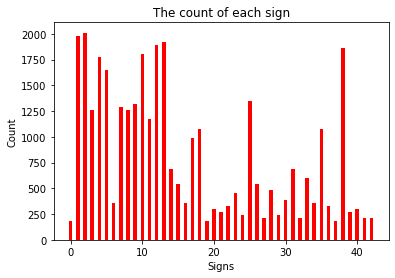

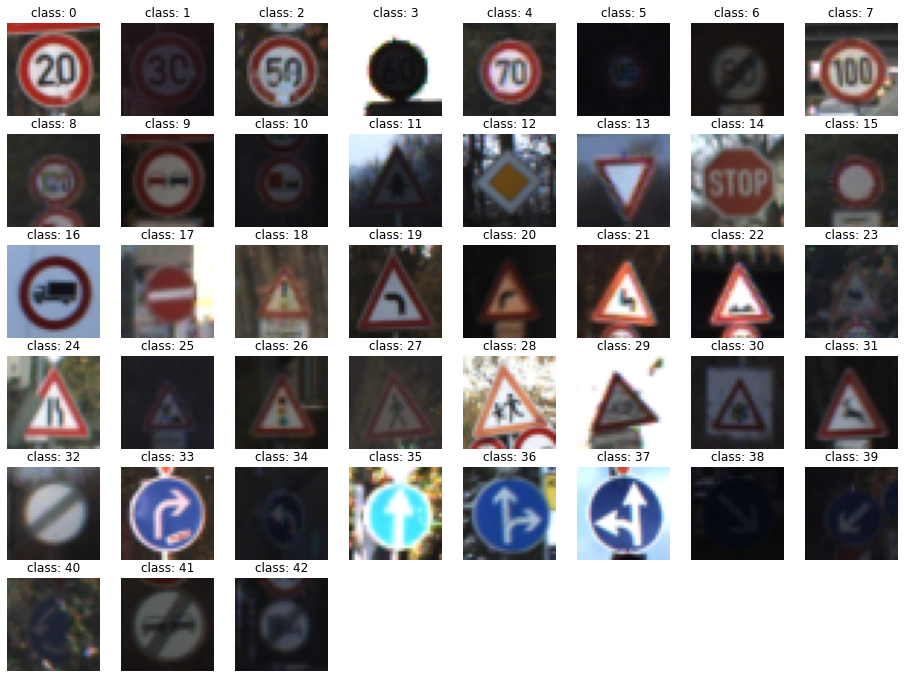

In [4]:
### Data exploration visualization.
fig, ax = plt.subplots()
ax.bar(range(n_classes), np.bincount(y_train), 0.5, color='r')
ax.set_xlabel('Signs')
ax.set_ylabel('Count')
ax.set_title('The count of each sign')
plt.show()

plt.figure(figsize=(16, 16))
for c in range(n_classes):
    i = random.choice(np.where(y_train == c)[0])
    plt.subplot(8, 8, c+1)
    plt.axis('off')
    plt.title('class: {}'.format(c))
    plt.imshow(X_train[i])

----

# Design and Test a Baseline Model Architecture

## Custom Dataset & DataLoader

In [5]:
class PickledDataset(Dataset):
    def __init__(self, file_path, transform=None):
        with open(file_path, mode='rb') as f:
            data = pickle.load(f)
            self.features = data['features']
            self.labels = data['labels']
            self.count = len(self.labels)
            self.transform = transform
        
    def __getitem__(self, index):
        feature = self.features[index]
        if self.transform is not None:
            feature = self.transform(feature)
        return (feature, self.labels[index])

    def __len__(self):
        return self.count

In [6]:
class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

## Baseline Model

In [7]:
class BaselineNet(nn.Module):
    def __init__(self, gray=False):
        super(BaselineNet, self).__init__()
        input_chan = 1 if gray else 3
        self.conv1 = nn.Conv2d(input_chan, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 43)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Training

In [8]:
torch.manual_seed(1)


In [9]:
train_dataset = PickledDataset(training_file, transform=transforms.ToTensor())
valid_dataset = PickledDataset(validation_file, transform=transforms.ToTensor())
test_dataset = PickledDataset(testing_file, transform=transforms.ToTensor())

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def to_device(x, y):
    return x.to(device), y.to(device, dtype=torch.int64)

train_loader = WrappedDataLoader(train_loader, to_device)
valid_loader = WrappedDataLoader(valid_loader, to_device)
test_loader = WrappedDataLoader(test_loader, to_device)

In [11]:
model = BaselineNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
n_epochs = 20

In [12]:
def loss_batch(model, loss_func, x, y, opt=None):
    loss = loss_func(model(x), y)
    
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(x)

In [13]:
def valid_batch(model, loss_func, x, y):
    output = model(x)
    loss = loss_func(output, y)
    pred = torch.argmax(output, dim=1)
    correct = pred == y.view(*pred.shape)
    
    return loss.item(), torch.sum(correct).item(), len(x)

In [14]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        # Train model
        model.train()
        losses, nums = zip(*[loss_batch(model, loss_func, x, y, opt) for x, y in train_dl])
        train_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        # Validation model
        model.eval()
        with torch.no_grad():
            losses, corrects, nums = zip(*[valid_batch(model, loss_func, x, y) for x, y in valid_dl])
            valid_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
            valid_accuracy = np.sum(corrects) / np.sum(nums) * 100
            print(f"[Epoch {epoch+1}/{epochs}] "
                  f"Train loss: {train_loss:.6f}\t"
                  f"Validation loss: {valid_loss:.6f}\t",
                  f"Validation accruacy: {valid_accuracy:.3f}%")

In [53]:
# Function to evaluate a trained model using test dataset
def evaluate(model, loss_func, dl):
    model.eval()
    with torch.no_grad():
        losses, corrects, nums = zip(*[valid_batch(model, loss_func, x, y) for x, y in dl])
        test_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        test_accuracy = np.sum(corrects) / np.sum(nums) * 100
        print(f"Test loss: {test_loss:.6f}\t"
              f"Test accruacy: {test_accuracy:.3f}%")


In [ ]:
fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader)
test_loss_1,nums = evaluate(model, criterion, test_loader,test_loss_1)

---
# Experiment and find tuning

## Data preprocessing

In [17]:
class CLAHE_GRAY:
    def __init__(self, clipLimit=2.5, tileGridSize=(4, 4)):
        self.clipLimit = clipLimit
        self.tileGridSize = tileGridSize

    def __call__(self, im):
        img_y = cv2.cvtColor(im, cv2.COLOR_RGB2YCrCb)[:,:,0]
        clahe = cv2.createCLAHE(clipLimit=self.clipLimit, tileGridSize=self.tileGridSize)
        img_y = clahe.apply(img_y)
        img_output = img_y.reshape(img_y.shape + (1,))
        return img_output

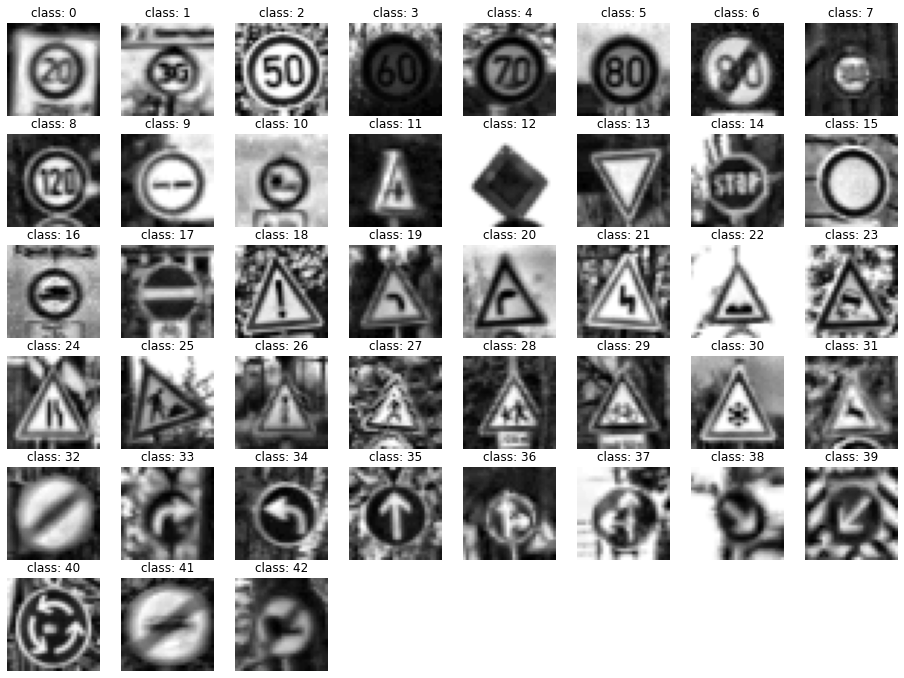

In [18]:
# Convert RGB image to Gray to get better accuracy
clahe = CLAHE_GRAY()
plt.figure(figsize=(16, 16))
for c in range(n_classes):
    i = random.choice(np.where(y_train == c)[0])
    plt.subplot(8, 8, c+1)
    plt.axis('off')
    plt.title('class: {}'.format(c))
    plt.imshow(clahe(X_train[i]).squeeze(), cmap='gray')

In [19]:
# Transform the input tensor
data_transforms = transforms.Compose([
    CLAHE_GRAY(),
    transforms.ToTensor()
])

train_dataset = PickledDataset(training_file, transform=data_transforms)
valid_dataset = PickledDataset(validation_file, transform=data_transforms)
test_dataset = PickledDataset(testing_file, transform=data_transforms)

train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=64, shuffle=True), to_device)
valid_loader = WrappedDataLoader(DataLoader(valid_dataset, batch_size=64, shuffle=False), to_device)
test_loader = WrappedDataLoader(DataLoader(test_dataset, batch_size=64, shuffle=False), to_device)

In [ ]:
model = BaselineNet(gray=True).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader)
evaluate(model, criterion, test_loader)

## Save preprocessed images

In [20]:
# Function to Convert the dataset into Gray and save it
def preprocess(path):
    if not os.path.exists(f"{path}/train_gray.p"):
        for dataset in ['train', 'valid', 'test']:
            with open(f"{path}/{dataset}.p", mode='rb') as f:
                data = pickle.load(f)
                X = data['features']
                y = data['labels']

            clahe = CLAHE_GRAY()
            for i in range(len(X)):
                X[i] = clahe(X[i])

            X = X[:, :, :, 0]
            with open(f"{path}/{dataset}_gray.p", "wb") as f:
                pickle.dump({"features": X.reshape(
                    X.shape + (1,)), "labels": y}, f)

In [21]:
preprocess('data')
training_file = 'data/train_gray.p'
validation_file = "data/valid_gray.p"
testing_file = "data/test_gray.p"

In [22]:
train_dataset = PickledDataset(training_file, transform=transforms.ToTensor())
valid_dataset = PickledDataset(validation_file, transform=transforms.ToTensor())
test_dataset = PickledDataset(testing_file, transform=transforms.ToTensor())

# Load the batched datasets to the device with/without shuffling
train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=64, shuffle=True), to_device)
valid_loader = WrappedDataLoader(DataLoader(valid_dataset, batch_size=64, shuffle=False), to_device)
test_loader = WrappedDataLoader(DataLoader(test_dataset, batch_size=64, shuffle=False), to_device)

## Handling imbalanced dataset

### Flipping

In [23]:
# Function to extend the dataset by various flipping
def extend_dataset(dataset):
    X = dataset.features
    y = dataset.labels
    num_classes = 43
    
    X_extended = np.empty([0] + list(dataset.features.shape)[1:], dtype=dataset.features.dtype)
    y_extended = np.empty([0], dtype = dataset.labels.dtype)
    
    horizontally_flippable = [11, 12, 13, 15, 17, 18, 22, 26, 30, 35]
    vertically_flippable = [1, 5, 12, 15, 17]
    both_flippable = [32, 40]
    cross_flippable = np.array([
        [19, 20],
        [33, 34],
        [36, 37],
        [38, 39],
        [20, 19],
        [34, 33],
        [37, 36],
        [39, 38]
    ])
    
    for c in range(num_classes):
        X_extended = np.append(X_extended, X[y==c], axis=0)  
        
        if c in horizontally_flippable:
            X_extended = np.append(X_extended, X[y==c][:,:,::-1,:], axis=0)
        if c in vertically_flippable:
            X_extended = np.append(X_extended, X[y==c][:,::-1,:,:], axis=0)
        if c in cross_flippable[:,0]:
            flip_c = cross_flippable[cross_flippable[:,0]==c][0][1]
            X_extended = np.append(X_extended, X[y==flip_c][:,:,::-1,:], axis=0)
        if c in both_flippable:
            X_extended = np.append(X_extended, X[y==c][:,::-1,::-1,:], axis=0)
        
        y_extended = np.append(y_extended, np.full(X_extended.shape[0]-y_extended.shape[0], c, dtype=y_extended.dtype))
    
    dataset.features = X_extended
    dataset.labels = y_extended
    dataset.count = len(y_extended)
    
    return dataset

In [24]:
train_dataset = extend_dataset(train_dataset)
train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=64, shuffle=True), to_device)

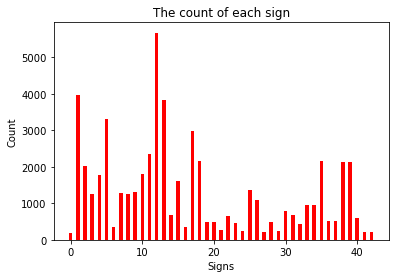

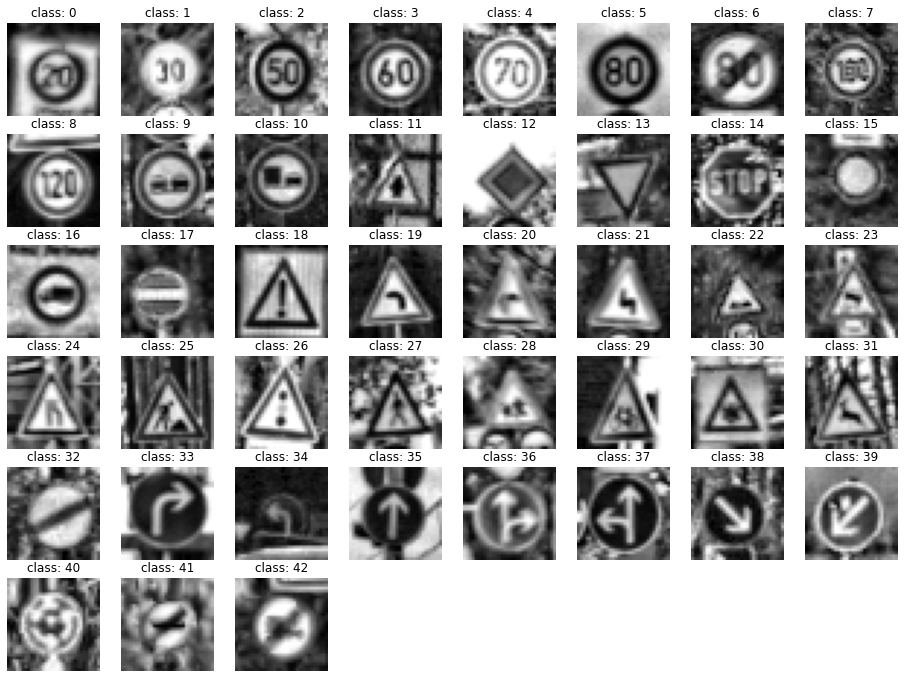

In [25]:
### Data exploration visualization.
fig, ax = plt.subplots()
ax.bar(range(n_classes), np.bincount(train_dataset.labels), 0.5, color='r')
ax.set_xlabel('Signs')
ax.set_ylabel('Count')
ax.set_title('The count of each sign')
plt.show()

plt.figure(figsize=(16, 16))
for c in range(n_classes):
    i = random.choice(np.where(train_dataset.labels == c)[0])
    plt.subplot(8, 8, c+1)
    plt.axis('off')
    plt.title('class: {}'.format(c))
    plt.imshow(train_dataset.features[i].squeeze(), cmap='gray')

In [ ]:
model = BaselineNet(gray=True).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader)
evaluate(model, criterion, test_loader)

### Augmentation

In [27]:
train_dataset = extend_dataset(PickledDataset(training_file))

# Weight sampler to balance the classes
class_sample_count = np.bincount(train_dataset.labels)
weights = 1 / np.array([class_sample_count[y] for y in train_dataset.labels])
samp = sampler.WeightedRandomSampler(weights, 43 * 20000)

train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=64, sampler=samp), to_device)

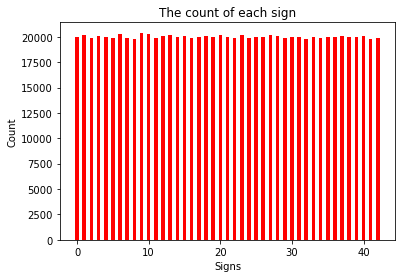

In [28]:
balanced_y_train = torch.LongTensor([]).to(device)

with torch.no_grad():
    for _, y in train_loader:
        balanced_y_train = torch.cat((balanced_y_train, y))

# Visualize balanced classes in the training set
fig, ax = plt.subplots()
ax.bar(range(n_classes), np.bincount(balanced_y_train.cpu().numpy()), 0.5, color='r')
ax.set_xlabel('Signs')
ax.set_ylabel('Count')
ax.set_title('The count of each sign')
plt.show()

In [29]:
# Transform the tensors 
train_data_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomApply([
        transforms.RandomRotation(20, resample=PIL.Image.BICUBIC),
        transforms.RandomAffine(0, translate=(0.2, 0.2), resample=PIL.Image.BICUBIC),
        transforms.RandomAffine(0, shear=20, resample=PIL.Image.BICUBIC),
        transforms.RandomAffine(0, scale=(0.8, 1.2), resample=PIL.Image.BICUBIC)
    ]),
    transforms.ToTensor()
])
test_data_transforms = transforms.ToTensor()

# Load the balanced, extended and transformed datasets 
train_dataset = extend_dataset(PickledDataset(training_file, transform=train_data_transforms))
valid_dataset = PickledDataset(validation_file, transform=test_data_transforms)
test_dataset = PickledDataset(testing_file, transform=test_data_transforms)

train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=64, sampler=samp), to_device)
valid_loader = WrappedDataLoader(DataLoader(valid_dataset, batch_size=64, shuffle=False), to_device)
test_loader = WrappedDataLoader(DataLoader(test_dataset, batch_size=64, shuffle=False), to_device)

In [30]:
# Function to convert image to numpy

def convert_image_np(img):
    img = img.numpy().transpose((1, 2, 0)).squeeze()
    return img

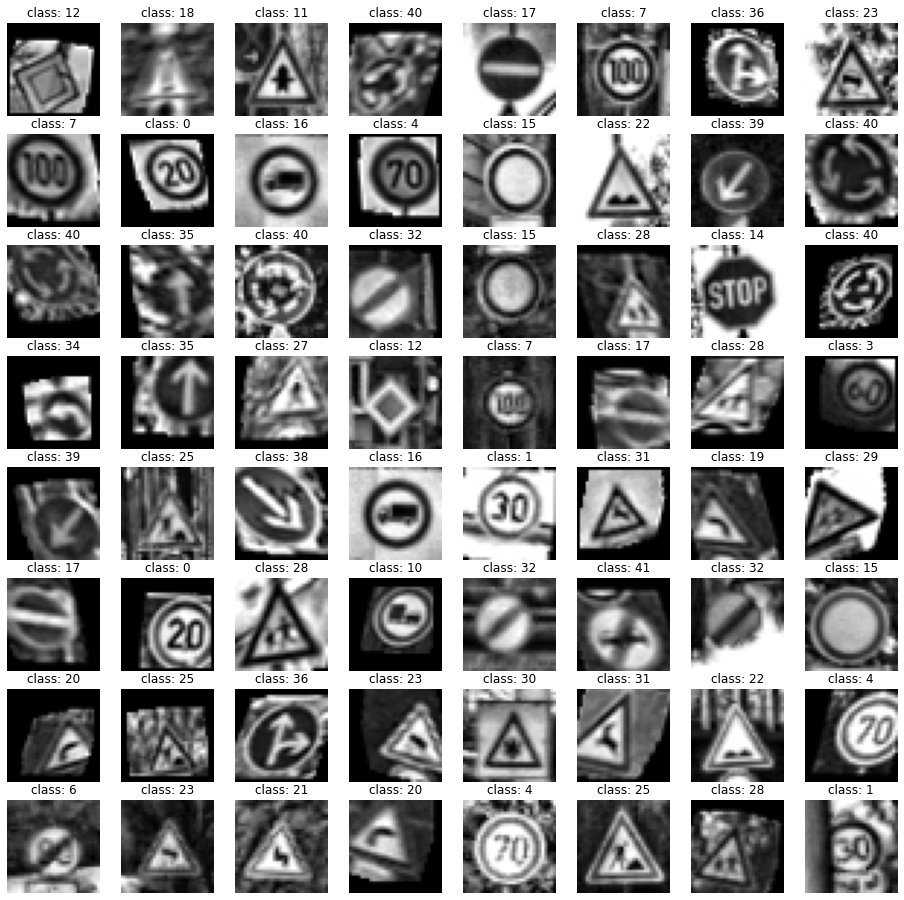

In [31]:
with torch.no_grad():
    x, y = next(iter(train_loader))
    plt.figure(figsize=(16, 16))
    for i in range(len(y)):
        plt.subplot(8, 8, i+1)
        plt.axis('off')
        plt.title('class: {}'.format(y[i]))
        plt.imshow(convert_image_np(x[i].cpu()), cmap='gray')

In [ ]:
# Train the baseline network with extended and balanced dataset 

model = BaselineNet(gray=True).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader)
evaluate(model, criterion, test_loader)

## Model

In [132]:
# Network model to classify traffic sign images

class TrafficSignNet(nn.Module):
    def __init__(self):
        super(TrafficSignNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 100, 5)
        self.conv1_bn = nn.BatchNorm2d(100)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(100, 150, 3)
        self.conv2_bn = nn.BatchNorm2d(150)
        self.conv3 = nn.Conv2d(150, 250, 1)
        self.conv3_bn = nn.BatchNorm2d(250)
        self.fc1 = nn.Linear(250 * 3 * 3, 350)
        self.fc1_bn = nn.BatchNorm1d(350)
        self.fc2 = nn.Linear(350, 43)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.pool(F.elu(self.conv1(x)))
        x = self.dropout(self.conv1_bn(x))
        x = self.pool(F.elu(self.conv2(x)))
        x = self.dropout(self.conv2_bn(x))
        x = self.pool(F.elu(self.conv3(x)))
        x = self.dropout(self.conv3_bn(x))
        x = x.view(-1, 250 * 3 * 3)
        x = F.elu(self.fc1(x))
        x = self.dropout(self.fc1_bn(x))
        x = self.fc2(x)
        return x

### Training

In [133]:
# Function to train the input model with given parameters

def fit(epochs, model, loss_func, opt, train_dl, valid_dl, patience=10):
    wait = 0
    valid_loss_min = np.Inf
    for epoch in range(epochs):
        # Train model
        model.train()
        losses, nums = zip(*[loss_batch(model, loss_func, x, y, opt) for x, y in train_dl])
        train_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        # Validation model
        model.eval()
        with torch.no_grad():
            losses, corrects, nums = zip(*[valid_batch(model, loss_func, x, y) for x, y in valid_dl])
            valid_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
            valid_accuracy = np.sum(corrects) / np.sum(nums) * 100
            print(f"[Epoch {epoch+1}/{epochs}] "
                  f"Train loss: {train_loss:.6f}\t"
                  f"Validation loss: {valid_loss:.6f}\t",
                  f"Validation accruacy: {valid_accuracy:.3f}%")
            # Save model if validation loss has decreased
            if valid_loss <= valid_loss_min:
                print(f"Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving model...")
                torch.save(model.state_dict(), 'model.pt')
                valid_loss_min = valid_loss
                wait = 0
            # Early stopping
            else:
                wait += 1
                if wait >= patience:
                    print(f"Terminated Training for Early Stopping at Epoch {epoch+1}")
                    return

### Evaluate the Model 

In [130]:
# Function to Calculate Confusion matrix

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.figure(figsize=(25,25))  
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('cmt.jpg')
    
# Function to get number of correct predictions made my the model
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

# Implement confusuion matrix
@torch.no_grad()
def get_all_preds(model, loader):
    all_preds = torch.tensor([])
    for batch in loader:
        images, labels = batch

        preds = model(images)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
    return all_preds

In [40]:
activation = {} # dictionary to store the activation of a layer

# Create hook function for forward pass to visualize feature maps

def create_hook(name):
    def hook(model, in_put, out):
    # copy the output of the given layer
         activation[name] = out.detach()
    return hook

In [55]:
# Plot network architecture by visualizing gradient_backward functionality
# This function will save network architecture in backward graph and return total parameters and total_trainable parameters

def get_network_configuration(model,batch_size,height,width,network_name):
    x = torch.zeros(batch_size, 1, height, width, dtype=torch.float, requires_grad=False)
    out = model(x)
    fig = make_dot(out)  # plot network
    make_dot(out).render(network_name, format="jpg")
    total_parameters = sum(p.numel() for p in model.parameters())
    total_trainable_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_parameters, total_trainable_parameters

In [108]:
# Function to get 10 samples from 5 different classes in the test dataset

def get_random_class_samples(test_dataset, n_classes, nr_test_sample):

    n_classes = n_classes 
    nr_test_sample = nr_test_sample #2 test samples required fpr each class
    id_list = []
    y1 = y.numpy() #convert into numpy
    random_class = random.sample(range(0, 43), 5) #generate 5 random classes
    #get the sample ids 
    for c in random_class:
        for j in range(nr_test_sample):
            idx = random.choice(np.where(test_dataset.labels == c)[0])
            id_list.append(idx)

    
    return id_list, random_class
    

In [138]:
# Train the model for 100 epochs using Adam optimizer and Cross entropy loss

n_epochs = 100
model = TrafficSignNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader)


In [139]:
# Load the trained model checkpoint and evaluate

check_point = torch.load('model_without_stn.pt', map_location=device)
model.load_state_dict(check_point)
evaluate(model, criterion, test_loader)

Test loss: 0.215834	Test accruacy: 93.769%


In [57]:
# Visualize network architecture of Model without STN in with backward graph and save the figure

total_parameters, total_trainable_parameters = get_network_configuration(model,1,32,32,"Network_without_STN")
print(total_parameters)
print(total_trainable_parameters)

980143
980143


In [135]:
# Print network layers

for param in model.parameters():
    param.requires_grad_(False)
print(list(map(lambda x: x[0], model.named_children())))


['conv1', 'conv1_bn', 'pool', 'conv2', 'conv2_bn', 'conv3', 'conv3_bn', 'fc1', 'fc1_bn', 'fc2', 'dropout']


### Visualize activation of a layer

Visualizing the activation maps to see how CNN is making decisions

64


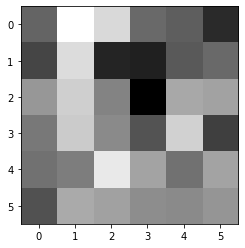

In [238]:
# Manually visulize  conv3 layer for trained model with network architecture without STN due to input dimensionality problem
# Can use function get_random_class_samples id dimensionality problem solved [B,C,H,W]-->[64.1,32,32]

n_classes = 5 # 
test_sample = 2
x, y = next(iter(test_loader))
id_list = []
y1 = y.numpy()
random_class = [25,  16, 38, 33, 11]
for c in random_class:
    for j in range (test_sample):
        idx = random.choice(np.where(y1 == c)[0])
        id_list.append(idx)
data= x
model.conv3.register_forward_hook(create_hook('conv3'))
output = model(data)
act = activation['conv3'].squeeze()
print(act.size(0))
j = 0
cl = 0
for id_n in id_list:
    plt.imshow(act[id_n][0], cmap='gray') # First activation map of each test sample
    plt.savefig('sample_id_'+str(id_n)+'_class_id_'+str(random_class[cl]) +'.jpg' ) 
    j = j+1 
    if j==2:
        j = 0
        cl = cl+1

### Confusion Matrix for the model 

Plot the Confusion matrix to see where the model fails

Confusion matrix, without normalization
[[ 54   0   0 ...   0   0   0]
 [  0 687   2 ...   0   0   0]
 [  0   1 679 ...   0   0   0]
 ...
 [  0   0   0 ...  76   0   0]
 [  0   0   0 ...   0  55   4]
 [  0   0   0 ...   0   0  90]]


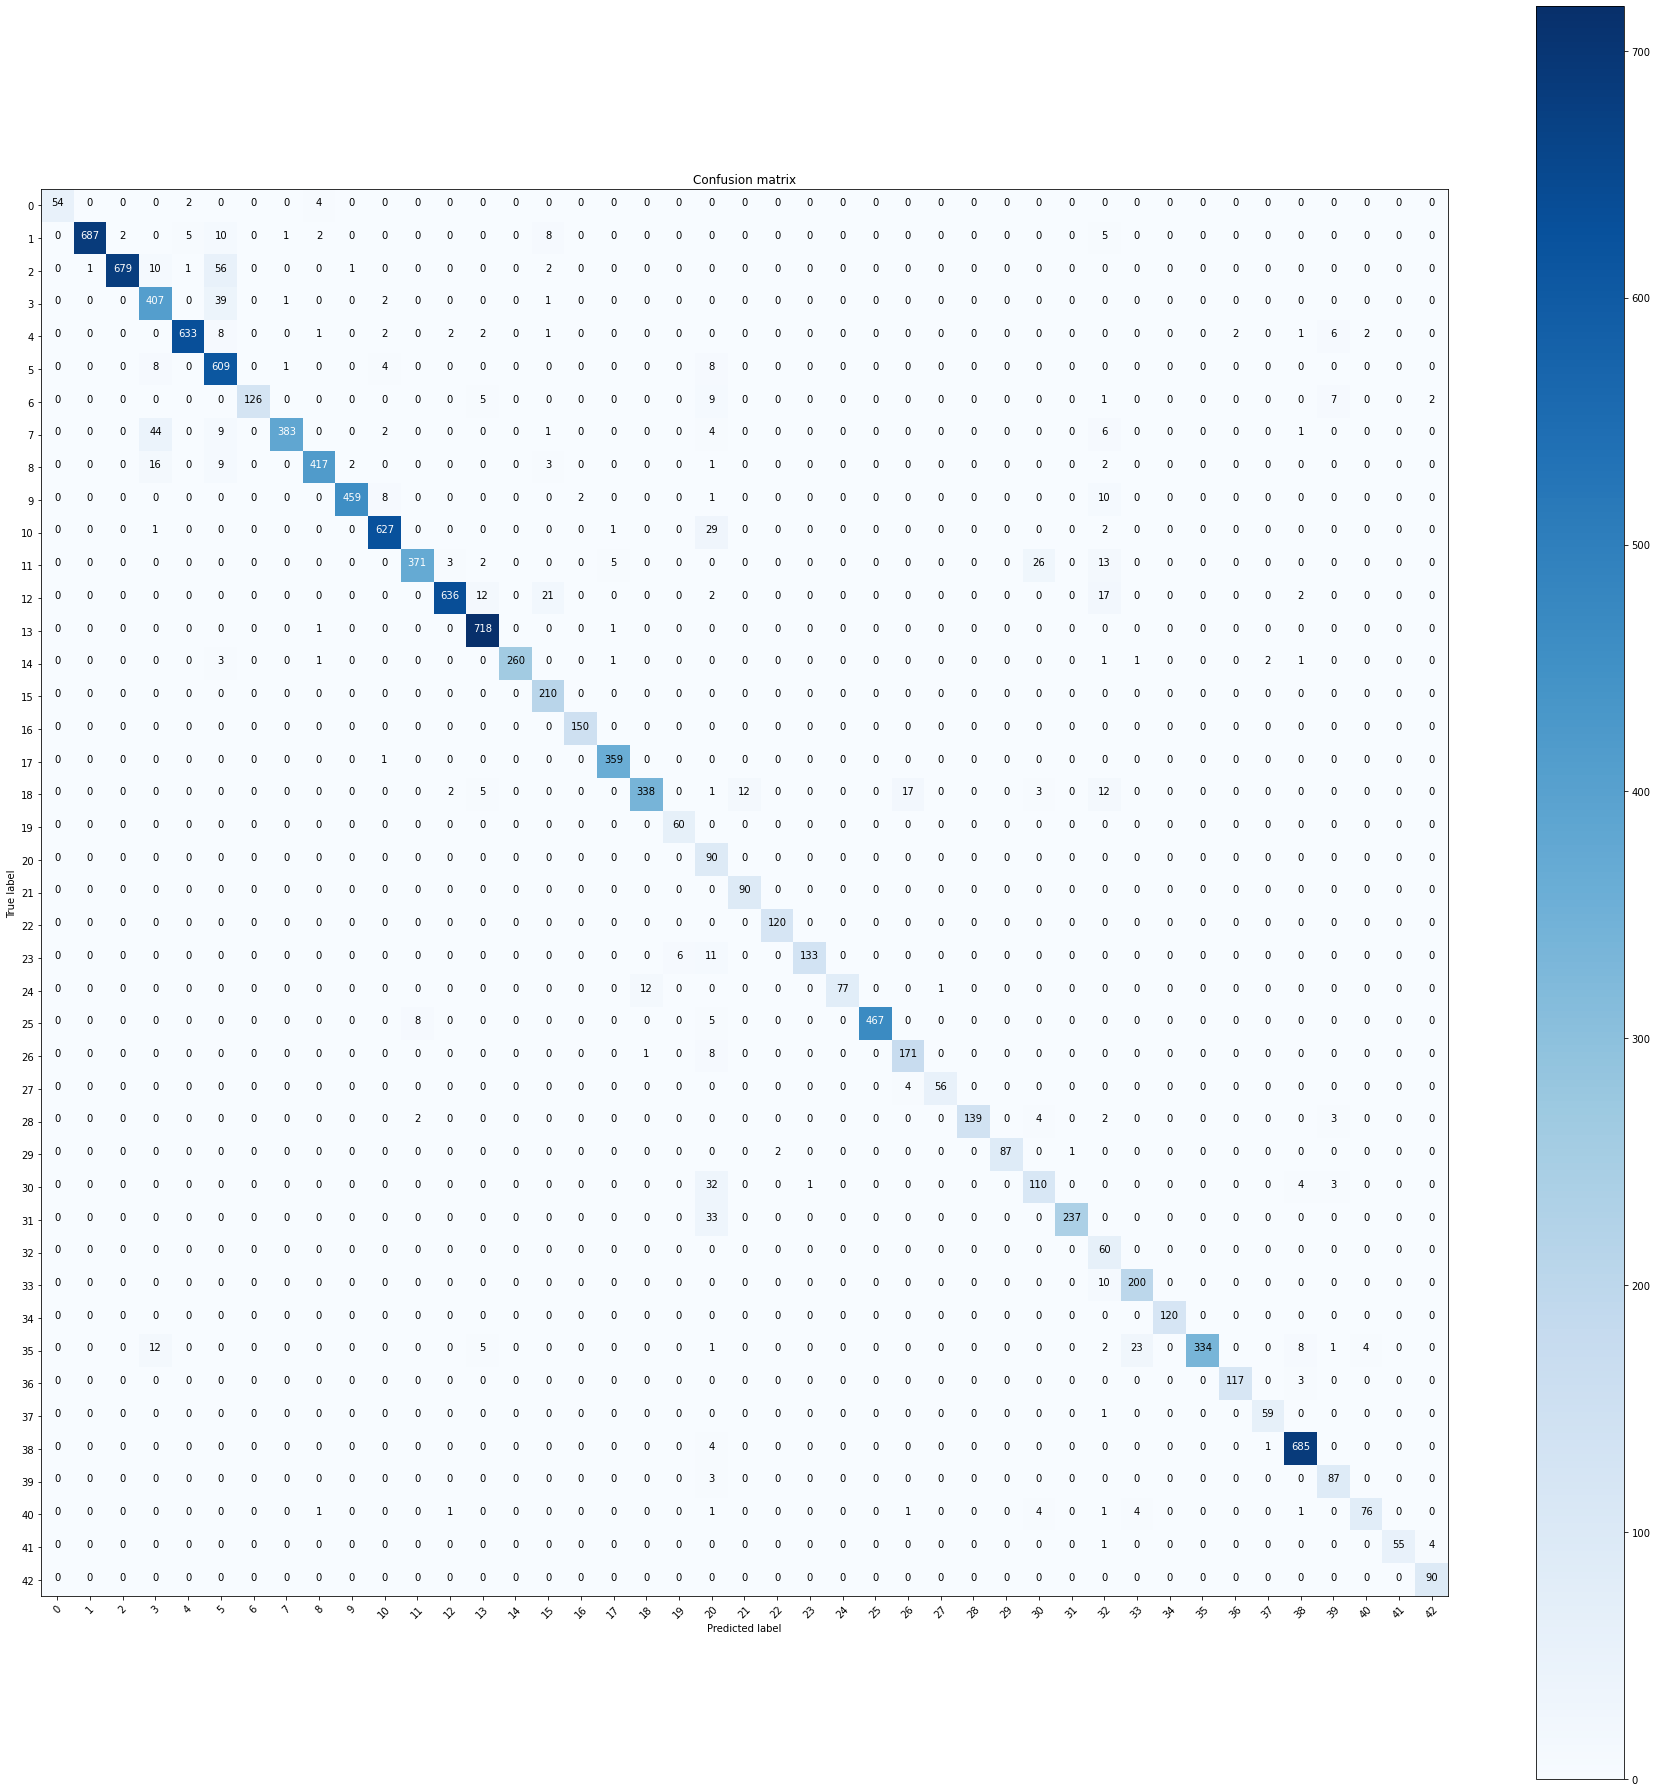

In [140]:
# Plot the confusion matrix
y_test_1 = torch.from_numpy(y_test)
with torch.no_grad():
    prediction_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64)
    test_preds = get_all_preds(model, prediction_loader)
preds_correct = get_num_correct(test_preds, y_test_1)
cm = confusion_matrix(y_test, test_preds.argmax(dim=1))
plot_confusion_matrix(cm, np.unique(y_test))

From the above confusion matrix we could see that the convolutional model fails in the case of input images which are zoomed out and distorted.

# Spatial transformer networks

In [119]:
class Stn(nn.Module):
    def __init__(self):
        super(Stn, self).__init__()
        # Spatial transformer localization-network
        self.loc_net = nn.Sequential(
            nn.Conv2d(1, 50, 7),
            nn.MaxPool2d(2, 2),
            nn.ELU(),
            nn.Conv2d(50, 100, 5),
            nn.MaxPool2d(2, 2),
            nn.ELU()
        )
        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(100 * 4 * 4, 100),
            nn.ELU(),
            nn.Linear(100, 3 * 2)
        )
        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))
        
    def forward(self, x):
        xs = self.loc_net(x)
        xs = xs.view(-1, 100 * 4 * 4)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x

In [120]:
class TrafficSignNet(nn.Module):
    def __init__(self):
        super(TrafficSignNet, self).__init__()
        self.stn = Stn()
        self.conv1 = nn.Conv2d(1, 100, 5)
        self.conv1_bn = nn.BatchNorm2d(100)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(100, 150, 3)
        self.conv2_bn = nn.BatchNorm2d(150)
        self.conv3 = nn.Conv2d(150, 250, 1)
        self.conv3_bn = nn.BatchNorm2d(250)
        self.fc1 = nn.Linear(250 * 3 * 3, 350)
        self.fc1_bn = nn.BatchNorm1d(350)
        self.fc2 = nn.Linear(350, 43)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.stn(x)
        x = self.pool(F.elu(self.conv1(x)))
        x = self.dropout(self.conv1_bn(x))
        x = self.pool(F.elu(self.conv2(x)))
        x = self.dropout(self.conv2_bn(x))
        x = self.pool(F.elu(self.conv3(x)))
        x = self.dropout(self.conv3_bn(x))
        x = x.view(-1, 250 * 3 * 3)
        x = F.elu(self.fc1(x))
        x = self.dropout(self.fc1_bn(x))
        x = self.fc2(x)
        return x

In [121]:
# Build the model and train using optimizer and loss finction

model = TrafficSignNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader)

# Evaluate Model with STN

In [126]:
# Load the check point of the trained model and evaluate it using test datset

check_point = torch.load('model.pt', map_location=device)
model.load_state_dict(check_point)
evaluate(model, criterion, test_loader)

Test loss: 0.221560	Test accruacy: 94.790%


In [ ]:
# Print the network layers

for param in model.parameters():
    param.requires_grad_(False)
print(list(map(lambda x: x[0], model.named_children())))


## Visualize the activation of a layer

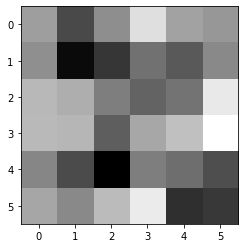

In [129]:
# Get 5 random classes and ids with 2 samples for each class and visualize activation function

id_list, random_class = get_random_class_samples(test_dataset, 5, 2)

# Function to visualize activation maps
def save_activation_maps(test_dataset,random_class,id_list):
    
    j = 0
    cl = 0
    for tst in id_list:

        data,_= test_dataset[tst]
        data.unsqueeze_(0)
        model.conv3.register_forward_hook(create_hook('conv3'))
        output = model(data)
        act = activation['conv3'].squeeze()
        plt.imshow(act[0], cmap='gray') # First activation map of test sample
        plt.savefig('sample_id_'+str(tst)+'_class_id_'+str(random_class[cl]) +'.jpg' ) 
        j = j+1 
        if j==2:
            j = 0
            cl = cl+1
#visulaize first activation map for 5 diffrent class with 10 diffrent samples for each class with count 2
save_activation_maps(test_dataset,random_class,id_list)   

The conv3 layer has 250 activation maps. Out of which first activation map is viewed. Since conv3 is a deep layer, the information of the image is not clearly visible in the above activation map.

## Visualizing the STN results

In [ ]:
# Function to visualize the STN layer output

def visualize_stn():
    with torch.no_grad():
        data = next(iter(test_loader))[0].to(device)

        input_tensor = data.cpu()
        transformed_tensor = model.stn(data).cpu()

        input_grid = convert_image_np(make_grid(input_tensor))
        transformed_grid = convert_image_np(make_grid(transformed_tensor))

        # Plot the results side-by-side
        fig, ax = plt.subplots(1, 2)
        fig.set_size_inches((16, 16))
        ax[0].imshow(input_grid)
        ax[0].set_title('Dataset Images')
        ax[0].axis('off')

        ax[1].imshow(transformed_grid)
        ax[1].set_title('Transformed Images')
        ax[1].axis('off')
        
visualize_stn()

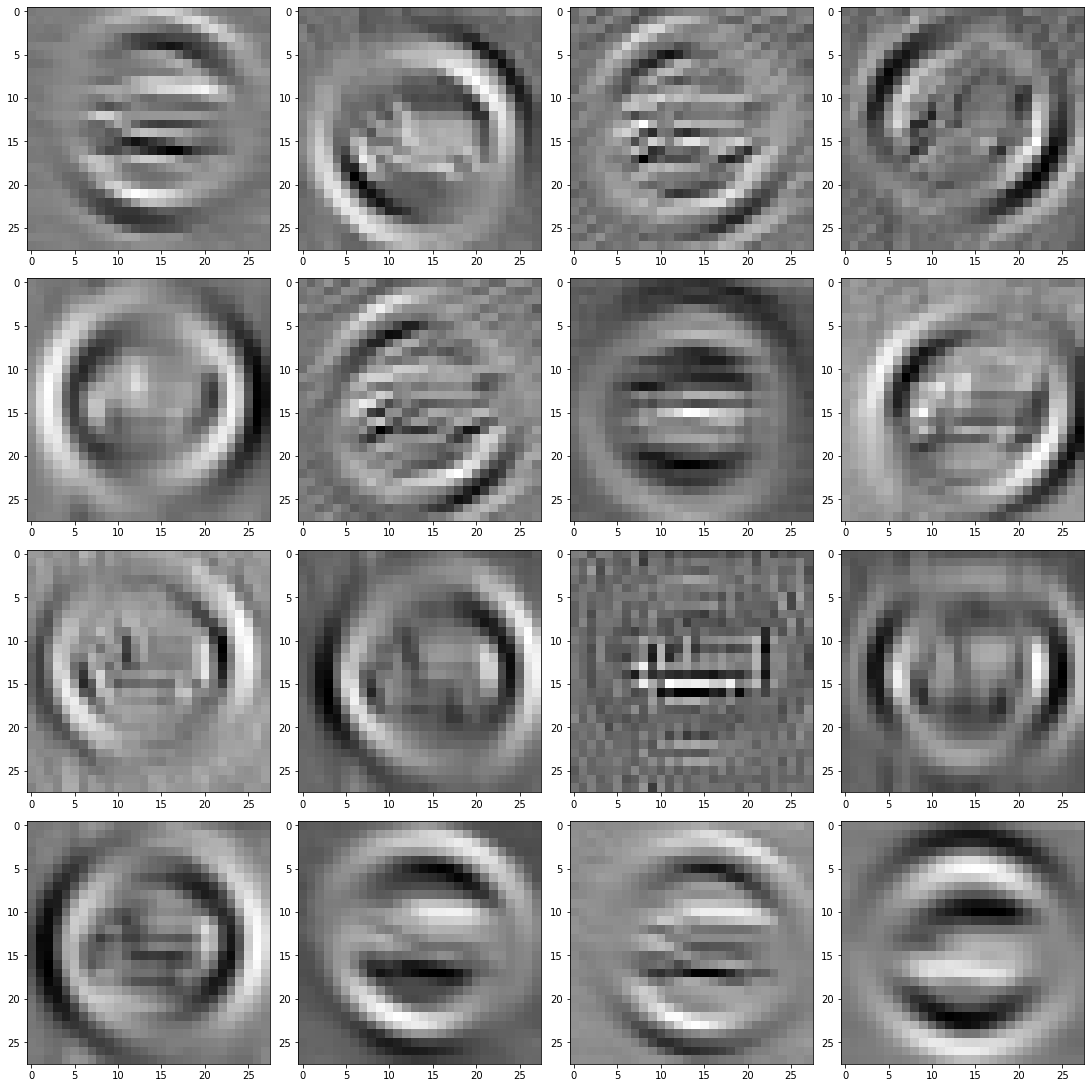

In [213]:
# conv layer 1 visualiztaion for one sample in test set
# first 16 activation maps out of 100 activation map of size 28x28 are displayed

fig, axarr = plt.subplots(4,4,figsize=(15,15),constrained_layout=True)
idx=0
for i in range(4):
    for  j in range(4):
        
        axarr[i][j].imshow(act[0][idx], cmap='gray')
        idx=idx+1

The conv1 layer has 100 activation maps. Out of which first 16 activation maps are viewed for a sample image. Since conv1 is a top layer of the network, we could see how the convolutional layer recognizes the content in the image. 

# Confusion Matrix for the model with STN

Plot the confusion matrix of the selected 10 images from the test dataset to the understand the confusion between classes in the model.



Confusion matrix, without normalization
[[ 57   0   0 ...   0   0   0]
 [  0 706   5 ...   0   0   0]
 [  0   1 718 ...   0   0   0]
 ...
 [  0   0   0 ...  86   0   0]
 [  0   0   0 ...   0  50   0]
 [  0   0   0 ...   0   0  90]]


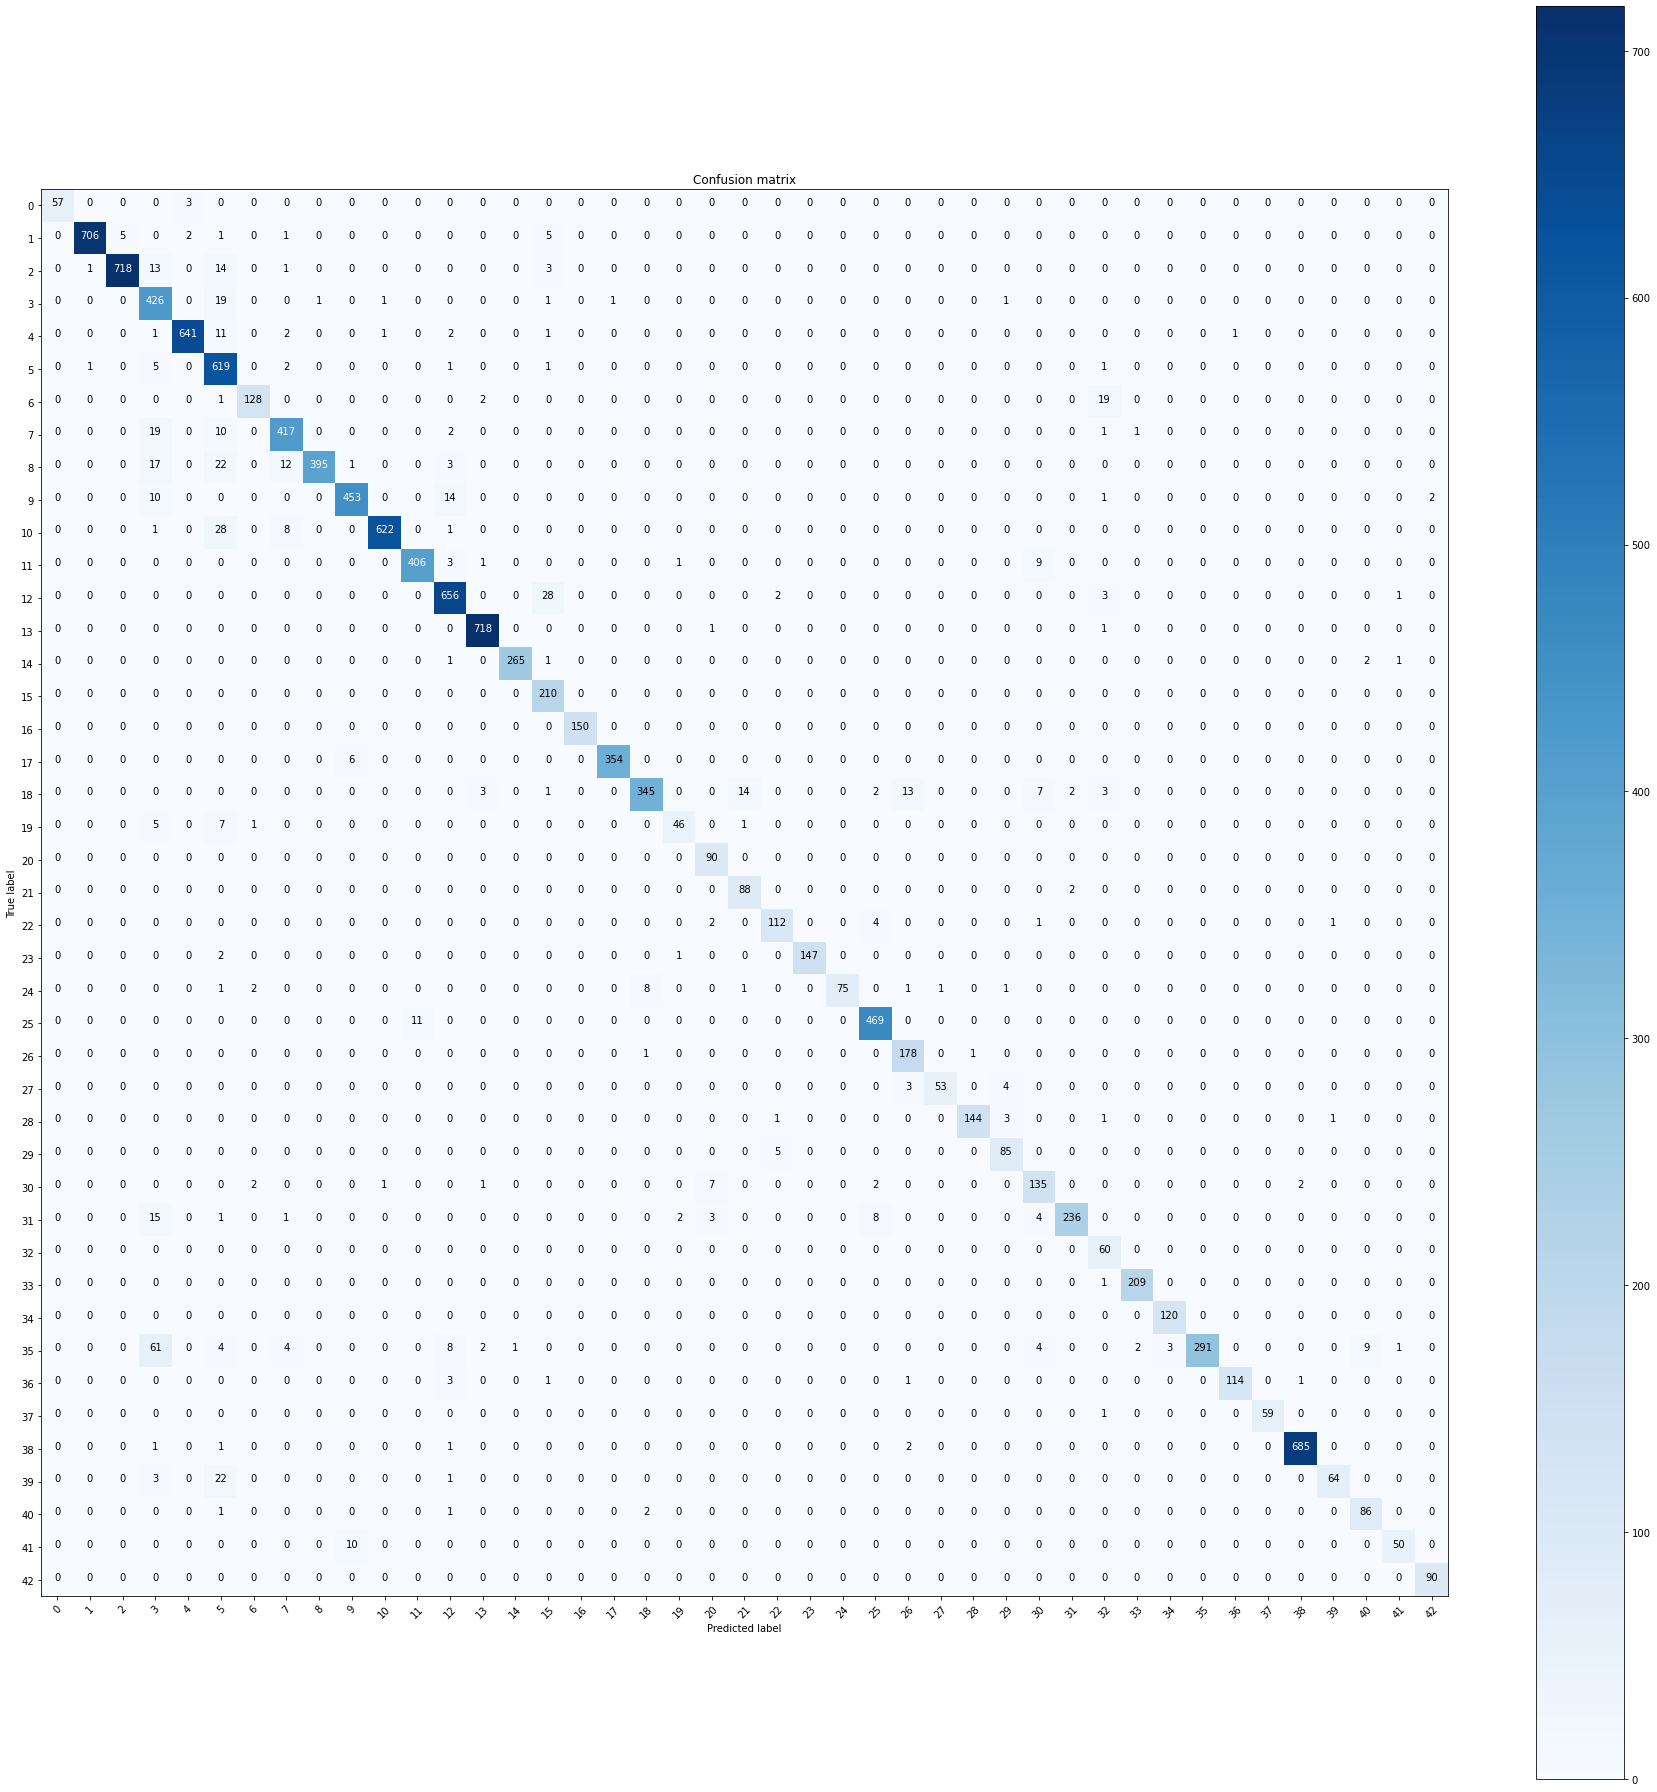

In [131]:
# Plot confusion matrix to understand confusion between classes in the model

y_test_1 = torch.from_numpy(y_test)
with torch.no_grad():
    prediction_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64)
    test_preds = get_all_preds(model, prediction_loader)
preds_correct = get_num_correct(test_preds, y_test_1)
cm = confusion_matrix(y_test, test_preds.argmax(dim=1))
plot_confusion_matrix(cm, np.unique(y_test))

Using STN layer improves the model performance. The above confusion matrix shows that the classes 0 to 8 (different speed limit signs) are misclassied among themselves. STN layer is capable of zooming and rotating the distorted image making it easier for the convolutional network to recognize images. 